In [211]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox import example
from openai import OpenAI_MDPToolbox as OpenAI
from gym import wrappers
# import gym
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Define Class

In [212]:
# {'State': None,
#   'Action': None,
#   'Reward': 23.172433847048566,
#   'Error': 14.1448095376563,
#   'Time': 0.0016689300537109375,
#   'V[0]': 4.475138121546962,
#   'Max V': 23.172433847048566,
#   'Mean V': 10.891732092662599,
#   'Iteration': 1},

In [217]:
class MDP():
    def __init__(self, problem, state_size, max_iter=int(1e10), is_run_q=False, is_slippery=True, r1=4, r2=2):
        if problem == 'forest':
            self.P, self.R = example.forest(S = state_size, r1=r1, r2=r2)
        elif problem == "FrozenLake-v1":
            custom_map = generate_random_map(size=state_size)
            self.problem = OpenAI(problem, desc=custom_map, is_slippery=is_slippery)
#             self.problem = OpenAI(problem)
            self.P, self.R = self.problem.P, self.problem.R
        elif problem == 'Taxi-v3':
#             custom_map = generate_random_map(size=state_size, p=0.9)
            self.problem = OpenAI(problem)
            self.P, self.R = self.problem.P, self.problem.R
        
        self.max_iter = max_iter
        self.is_run_q = is_run_q
        self.r1 = r1
        self.r2 = r2
        
        self.pi_df = pd.DataFrame()
        self.vi_df = pd.DataFrame()
        self.q_df = pd.DataFrame()
        
        self.best_gamma = {}
        self.time_record = {}
        

        self.run_pi()
        print('PI completed')
        self.run_vi()
        print('VI completed')
        if is_run_q == True:
            self.run_q()
            print('Q-Learning completed')
        
    def run_pi(self):
        for gamma in [0.1, 0.3, 0.5, 0.7, 0.9]:
            pi = PolicyIteration(self.P, self.R, gamma, max_iter = self.max_iter)
            output = pi.run()
            out_df = pd.DataFrame(output)
            out_df['gamma'] = gamma
            self.pi_df = self.pi_df.append(out_df)
        rowid = self.pi_df['Mean V'].argmax()
        best_gamma = self.pi_df.iloc[rowid]['gamma']
        self.best_gamma['pi'] = best_gamma
        self.pi = PolicyIteration(self.P, self.R, best_gamma, max_iter = self.max_iter)
        start = time.time()
        self.pi.run()
        duration = time.time()-start
        self.time_record['pi'] = duration
            
    def run_vi(self):
        for gamma in [0.1, 0.3, 0.5, 0.7, 0.9]:
            vi = ValueIteration(self.P, self.R, gamma, max_iter = self.max_iter)
            output = vi.run()
            out_df = pd.DataFrame(output)
            out_df['gamma'] = gamma
            self.vi_df = self.vi_df.append(out_df)
        rowid = self.vi_df['Mean V'].argmax()
        best_gamma = self.vi_df.iloc[rowid]['gamma']
        self.best_gamma['vi'] = best_gamma
        self.vi = ValueIteration(self.P, self.R, best_gamma, max_iter = self.max_iter)
        start = time.time()
        self.vi.run()
        duration = time.time()-start
        self.time_record['vi'] = duration
        
    def run_q(self):
        for gamma in [0.5, 0.9]:
            for eps in [0, 0.1, 0.5, 1]:
                for alpha in [0.1, 0.5, 1]:
                    q = QLearning(self.P, self.R, gamma, epsilon=eps, epsilon_decay=0.999, alpha=alpha, n_iter=10000)
                    out_df = pd.DataFrame(q.run())
                    out_df['epsilon'] = eps
                    out_df['alpha'] = alpha
                    out_df['gamma'] = gamma
                    self.q_df = self.q_df.append(out_df)
        rowid = self.q_df['Mean V'].argmax()
        self.best_eps = self.q_df.iloc[rowid]['epsilon']
        self.best_alpha = self.q_df.iloc[rowid]['alpha']
        self.best_gamma['q'] = self.q_df.iloc[rowid]['gamma']
        self.q = QLearning(self.P, self.R, self.best_gamma['q'], epsilon=self.best_eps, alpha=self.best_alpha, n_iter=10000)
        start = time.time()
        self.q.run()
        duration = time.time()-start
        self.time_record['q'] = duration
    
    # hyper-paramter tuning
    def gamma_plot(self, df, metric = 'Mean V'):
        for gamma in [0.1, 0.3, 0.5, 0.7, 0.9]:
            plt.plot(df[df['gamma']==gamma][metric], label=f'gamma={gamma}')
        plt.legend()
        plt.grid()
        plt.xlabel('Iterations')
        plt.ylabel('Mean V')
        plt.title('Gamma Plot')
    
    def epsilon_plot(self, gamma=0.9, metric='Mean V'):
        
        for eps in [0, 0.1, 0.5, 1]:
            for alpha in [0.1, 0.5, 1]:
                q_df_plot = self.q_df[(self.q_df['epsilon']==eps)&(self.q_df['alpha']==alpha)&\
                                     (self.q_df['gamma']==gamma)]
                plt.plot(q_df_plot[metric], label=f'Epsilon={eps}, Alpha={alpha}')
        plt.xlabel("Iterations")
        plt.ylabel(metric)
        plt.legend()
        plt.grid()
        plt.title('Hyperparameter Tuning')
        
    def compare_plot(self, metric, title=None, xlim=None):
        plt.plot(self.pi_df[self.pi_df['gamma']==self.best_gamma['pi']][metric], label = 'Policy Iteration')
        plt.plot(self.vi_df[self.vi_df['gamma']==self.best_gamma['vi']][metric], label = 'Value Iteration')
        if self.is_run_q == True:
            q_df_plot = self.q_df[(self.q_df['epsilon']==self.best_eps)&(self.q_df['alpha']==self.best_alpha)\
                                      &(self.q_df['gamma']==self.best_gamma['q'])]
            plt.plot(q_df_plot[metric], label='Q-Learning')
        plt.xlabel('Iterations')
        plt.ylabel(metric)
        plt.xlim(left=0, right=xlim)
        plt.grid()
        plt.legend()
        if title==None:
            plt.title(f'{metric} over Iterations')
        else:
            plt.title(title)
        
    def metric_plot(self, metric, algo, title=None):
        if algo == 'pi':
            plt.plot(self.pi_df[self.pi_df['gamma']==self.best_gamma['pi']][metric], label = 'Policy Iteration')
        elif algo == 'vi':
            plt.plot(self.vi_df[self.vi_df['gamma']==self.best_gamma['vi']][metric], label = 'Value Iteration')
        elif algo == 'q' and self.is_run_q==True:
            q_df_plot = self.q_df[(self.q_df['epsilon']==self.best_eps)&(self.q_df['alpha']==self.best_alpha)\
                                  &(self.q_df['gamma']==self.best_gamma['q'])]
            plt.plot(q_df_plot[metric], label='Q-Learning')
        plt.xlabel('Iterations')
        plt.ylabel(metric)
        plt.grid()
        plt.legend()
        if title==None:
            plt.title(f'{metric} over Iterations')
        else:
            plt.title(title)
    

In [149]:
## https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa
def run_episode(env, policy, gamma, render = True):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    st = time.time()
    while True:
        if render:
            env.render()
        obs = obs[0]
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done or time.time()-st > 0.01:
            break
    return total_reward

def extract_policy(env,v, gamma):
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma):
    v = np.zeros(env.observation_space.n)
    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v

def evaluate_policy(env, policy, gamma , n = 100):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)

def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')


    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.show()
#     plt.savefig([title, '.png'])
    plt.close()

    return (plt)

def colors_lake():
    return {
        b'S': 'red',
        b'F': 'skyblue',
        b'H': 'black',
        b'G': 'green',
    }

def directions_lake():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }

In [139]:
def policy_iteration(env, gamma):
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  
    max_iters = 10000
    desc = env.unwrapped.desc
    for i in range(max_iters):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(env,old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            k=i+1
            break
        policy = new_policy
        k = 1+1
        if i % 50 == 0:
            print(i)
    plot = plot_policy_map('PI Policy Map, Iteration '+ str(i) + ', Gamma: ' + str(gamma),policy.reshape(map_size,map_size),desc,colors_lake(),directions_lake())
    return policy,k

# Forest (Non Grid)

In [244]:
%%time
forest_mdp = MDP(problem = 'forest', state_size=10, is_run_q=True)

PI completed
VI completed
Q-Learning completed
CPU times: user 8.46 s, sys: 243 ms, total: 8.7 s
Wall time: 8.84 s


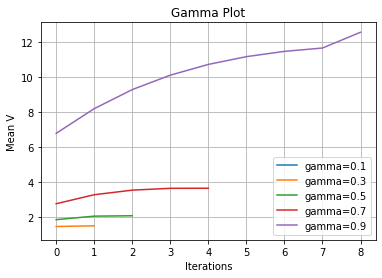

In [22]:
forest_mdp.gamma_plot(forest_mdp.pi_df)

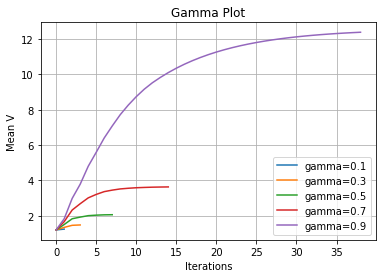

In [23]:
forest_mdp.gamma_plot(forest_mdp.vi_df)

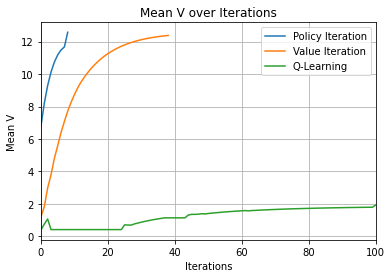

In [36]:
forest_mdp.compare_plot('Mean V', xlim=100)

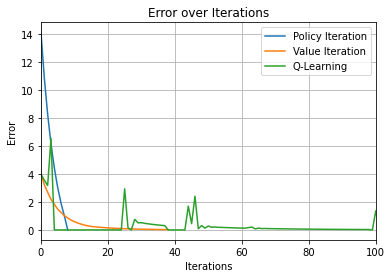

In [35]:
forest_mdp.compare_plot('Error', xlim = 100)

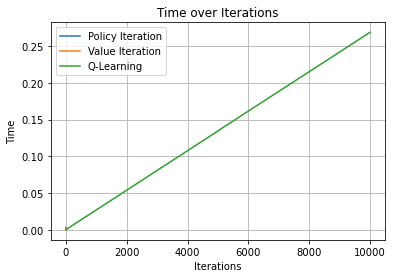

In [430]:
forest_mdp.compare_plot('Time')

Best gamma:  0.9
Best epsilon:  1.0
Best alpha:  1.0


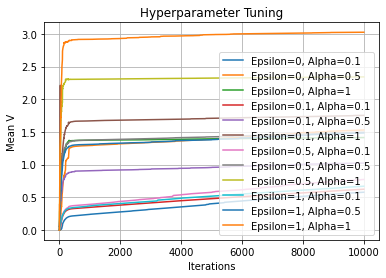

In [447]:
gamma = forest_mdp.best_gamma['q']
print('Best gamma: ', gamma)
forest_mdp.epsilon_plot(gamma)
print('Best epsilon: ', forest_mdp.best_eps)
print("Best alpha: ", forest_mdp.best_alpha)

In [245]:
forest_mdp.time_record

{'pi': 0.003074169158935547,
 'vi': 0.0017769336700439453,
 'q': 0.31855320930480957}

In [433]:
gamma = forest_mdp.best_gamma['pi']
num_iters = forest_mdp.pi_df[forest_mdp.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = forest_mdp.best_gamma['vi']
num_iters = forest_mdp.vi_df[forest_mdp.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = forest_mdp.best_gamma['q']
num_iters = forest_mdp.q_df[forest_mdp.q_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

9
39
10000


In [58]:
tmp_df = forest_mdp.pi_df[forest_mdp.pi_df['gamma']==forest_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

tmp_df = forest_mdp.vi_df[forest_mdp.vi_df['gamma']==forest_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

tmp_df = forest_mdp.q_df[forest_mdp.q_df['gamma']==forest_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

12.577121016812187 0.0038797855377197266
12.379328690952546 0.0018420219421386719
5.973757855967574 0.2818267345428467


## S=500

In [246]:
forest_mdp_s500 = MDP(problem = 'forest', state_size=500, is_run_q=True)

PI completed
VI completed
Q-Learning completed


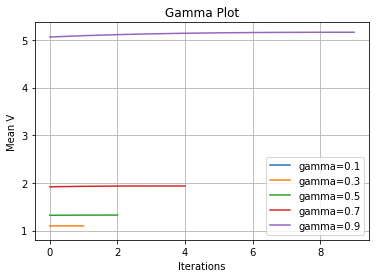

In [435]:
forest_mdp_s500.gamma_plot(forest_mdp_s500.pi_df)

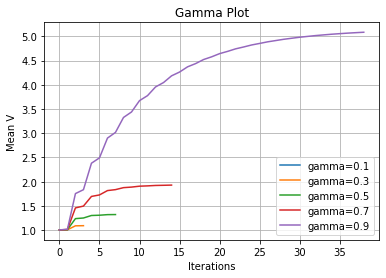

In [443]:
forest_mdp_s500.gamma_plot(forest_mdp_s500.vi_df)

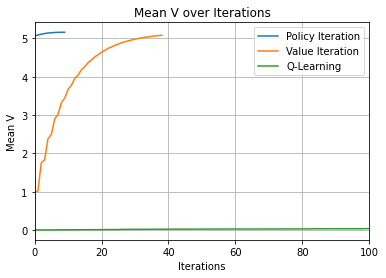

In [40]:
forest_mdp_s500.compare_plot('Mean V', xlim=100)

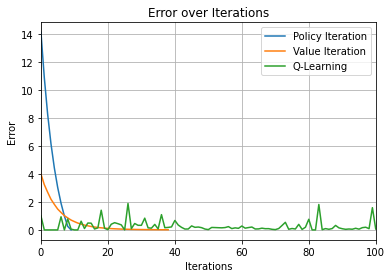

In [39]:
forest_mdp_s500.compare_plot('Error', xlim=100)

Best gamma:  0.9
Best epsilon:  0.5
Best alpha:  1.0


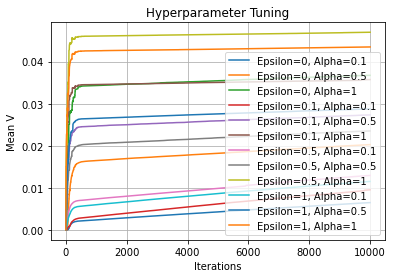

In [445]:
gamma = forest_mdp_s500.best_gamma['q']
print('Best gamma: ', gamma)
forest_mdp_s500.epsilon_plot(gamma)
print('Best epsilon: ', forest_mdp_s500.best_eps)
print("Best alpha: ", forest_mdp_s500.best_alpha)

In [247]:
forest_mdp_s500.time_record

{'pi': 0.05921363830566406,
 'vi': 0.008968830108642578,
 'q': 0.3956170082092285}

In [56]:
tmp_df = forest_mdp_s500.pi_df[forest_mdp_s500.pi_df['gamma']==forest_mdp_s500.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

tmp_df = forest_mdp_s500.vi_df[forest_mdp_s500.vi_df['gamma']==forest_mdp_s500.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

tmp_df = forest_mdp_s500.q_df[forest_mdp_s500.q_df['gamma']==forest_mdp_s500.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv, run_time)

5.1630273494670815 0.036441802978515625
5.0852104996382765 0.0036821365356445312
0.0545296750441378 0.34512877464294434


In [103]:
gamma = forest_mdp_s500.best_gamma['pi']
num_iters = forest_mdp_s500.pi_df[forest_mdp_s500.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = forest_mdp_s500.best_gamma['vi']
num_iters = forest_mdp_s500.vi_df[forest_mdp_s500.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = forest_mdp_s500.best_gamma['q']
num_iters = forest_mdp_s500.q_df[forest_mdp_s500.q_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

10
39
10000


## r1=10, r2=2

In [41]:
%%time
forest_mdp_r110 = MDP(problem = 'forest', state_size=500, is_run_q=True, r1=10)

CPU times: user 11.2 s, sys: 586 ms, total: 11.8 s
Wall time: 9.31 s


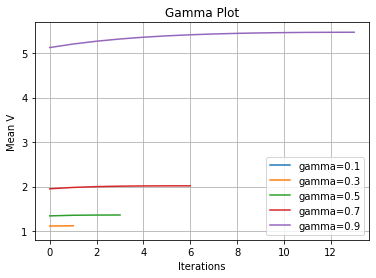

In [42]:
forest_mdp_r110.gamma_plot(forest_mdp_r110.pi_df)

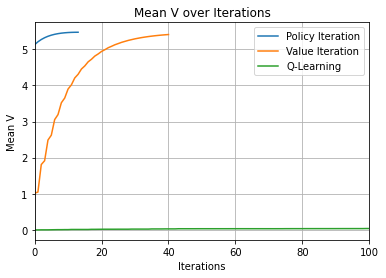

In [44]:
forest_mdp_r110.compare_plot('Mean V', xlim=100)

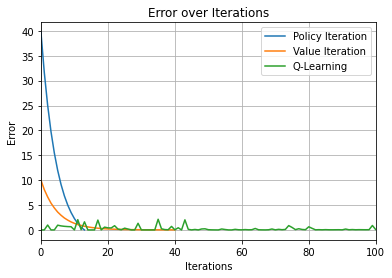

In [45]:
forest_mdp_r110.compare_plot('Error', xlim=100)

In [46]:
%%time
forest_mdp_r210 = MDP(problem = 'forest', state_size=500, is_run_q=True, r2=10)

CPU times: user 10.9 s, sys: 463 ms, total: 11.3 s
Wall time: 9.05 s


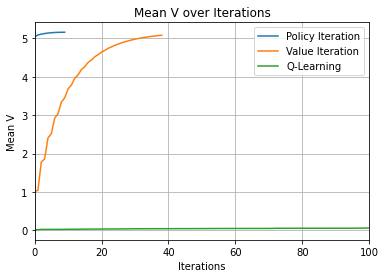

In [47]:
forest_mdp_r210.compare_plot('Mean V', xlim=100)

# Frozen Lake (Grid)

## Slippery

In [230]:
%%time
lake_mdp_slippery = MDP(problem = 'FrozenLake-v1', state_size=4, is_run_q=True, is_slippery=True)

PI completed
VI completed
Q-Learning completed
CPU times: user 8.48 s, sys: 211 ms, total: 8.69 s
Wall time: 8.72 s


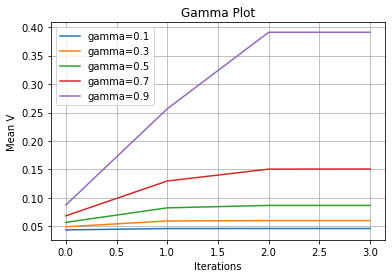

In [403]:
lake_mdp_slippery.gamma_plot(lake_mdp_slippery.pi_df)

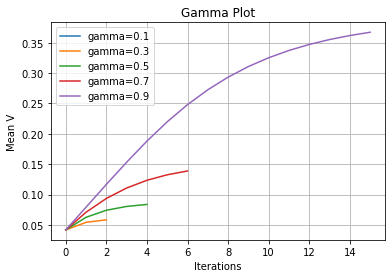

In [404]:
lake_mdp_slippery.gamma_plot(lake_mdp_slippery.vi_df)

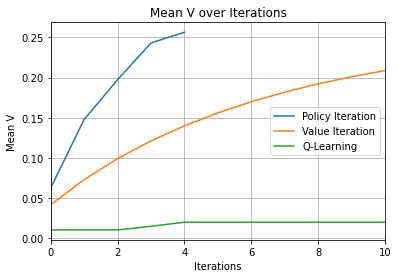

In [89]:
lake_mdp_slippery.compare_plot('Mean V', xlim=10)

In [421]:
meanv = lake_mdp_slippery.pi_df[lake_mdp_slippery.pi_df['gamma']==lake_mdp_slippery.best_gamma['pi']]['Mean V'].max()
run_time = lake_mdp_slippery.pi_df[lake_mdp_slippery.pi_df['gamma']==lake_mdp_slippery.best_gamma['pi']]['Time'].max()
print(meanv, run_time)

0.2383011453583676 0.001280069351196289


Best gamma:  0.9
Best epsilon:  0.5
Best alpha:  0.5


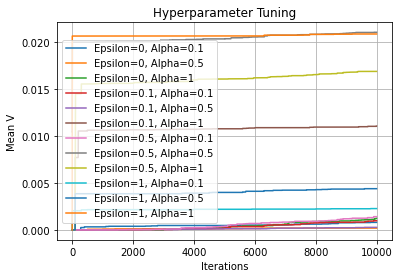

In [65]:
gamma = lake_mdp_slippery.best_gamma['q']
print('Best gamma: ', gamma)
lake_mdp_slippery.epsilon_plot(gamma)
print('Best epsilon: ', lake_mdp_slippery.best_eps)
print("Best alpha: ", lake_mdp_slippery.best_alpha)

In [231]:
lake_mdp_slippery.time_record

{'pi': 0.0021126270294189453,
 'vi': 0.00041294097900390625,
 'q': 0.31190919876098633}

In [97]:
tmp_df = lake_mdp_slippery.pi_df[lake_mdp_slippery.pi_df['gamma']==lake_mdp_slippery.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp_slippery.vi_df[lake_mdp_slippery.vi_df['gamma']==lake_mdp_slippery.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp_slippery.q_df[lake_mdp_slippery.q_df['gamma']==lake_mdp_slippery.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

0.25638911489574434
0.23024864933699976
0.02102924499070271


In [104]:
gamma = lake_mdp_slippery.best_gamma['pi']
num_iters = lake_mdp_slippery.pi_df[lake_mdp_slippery.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp_slippery.best_gamma['vi']
num_iters = lake_mdp_slippery.vi_df[lake_mdp_slippery.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp_slippery.best_gamma['q']
num_iters = lake_mdp_slippery.q_df[lake_mdp_slippery.q_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

5
15
10000


In [178]:
np.reshape(lake_mdp_slippery.pi.policy, (4, 4))

array([[3, 3, 3, 2],
       [3, 0, 0, 2],
       [0, 0, 0, 2],
       [1, 1, 1, 0]])

In [179]:
np.reshape(lake_mdp_slippery.vi.policy, (4, 4))

array([[3, 3, 3, 2],
       [3, 0, 0, 2],
       [0, 0, 0, 2],
       [1, 1, 1, 0]])

In [180]:
np.reshape(lake_mdp_slippery.q.policy, (4, 4))

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]])

## Non-Slippery

In [232]:
%%time
lake_mdp = MDP(problem = 'FrozenLake-v1', state_size=4, is_run_q=True, is_slippery=False)

PI completed
VI completed
Q-Learning completed
CPU times: user 8.28 s, sys: 65.6 ms, total: 8.34 s
Wall time: 8.36 s


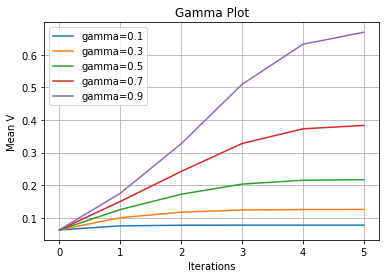

In [407]:
lake_mdp.gamma_plot(lake_mdp.pi_df)

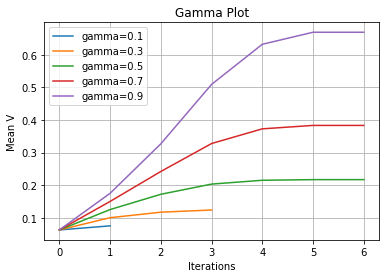

In [408]:
lake_mdp.gamma_plot(lake_mdp.vi_df)

Best gamma:  0.9
Best epsilon:  0.5
Best alpha:  1.0


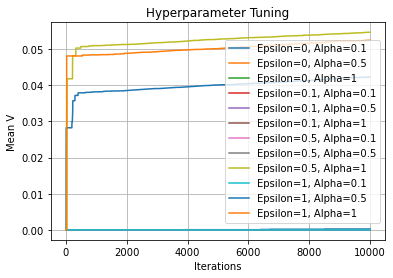

In [68]:
gamma = lake_mdp.best_gamma['q']
print('Best gamma: ', gamma)
lake_mdp.epsilon_plot(gamma)
print('Best epsilon: ', lake_mdp.best_eps)
print("Best alpha: ", lake_mdp.best_alpha)

In [417]:
meanv = lake_mdp.pi_df[lake_mdp.pi_df['gamma']==lake_mdp.best_gamma['pi']]['Mean V'].max()
run_time = lake_mdp.pi_df[lake_mdp.pi_df['gamma']==lake_mdp.best_gamma['pi']]['Time'].max()
print(meanv, run_time)

0.6690493750000001 0.0016169548034667969


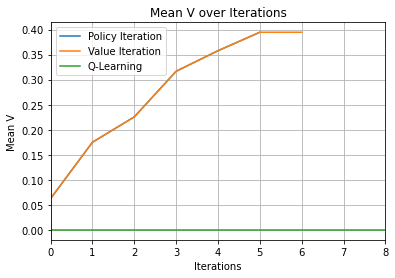

In [91]:
lake_mdp.compare_plot('Mean V', xlim=8)

In [233]:
lake_mdp.time_record

{'pi': 0.0018830299377441406,
 'vi': 0.00034880638122558594,
 'q': 0.3083150386810303}

In [98]:
tmp_df = lake_mdp.pi_df[lake_mdp.pi_df['gamma']==lake_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp.vi_df[lake_mdp.vi_df['gamma']==lake_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp.q_df[lake_mdp.q_df['gamma']==lake_mdp.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

0.39466187500000005
0.39466187500000005
0.022177792693622772


In [105]:
gamma = lake_mdp.best_gamma['pi']
num_iters = lake_mdp.pi_df[lake_mdp.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp.best_gamma['vi']
num_iters = lake_mdp.vi_df[lake_mdp.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp.best_gamma['q']
num_iters = lake_mdp.q_df[lake_mdp.q_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

6
7
10000


In [182]:
np.reshape(lake_mdp.pi.policy, (4, 4))

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 0]])

In [184]:
np.reshape(lake_mdp.vi.policy, (4, 4))

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 0]])

In [185]:
np.reshape(lake_mdp.q.policy, (4, 4))

array([[1, 1, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [2, 2, 2, 0]])

# Frozen Lake 8x8 (Grid)

In [234]:
%%time
lake_mdp_slippery_s8 = MDP(problem = 'FrozenLake-v1', state_size=8, is_run_q=False, is_slippery=True)

PI completed
VI completed
CPU times: user 58.5 ms, sys: 13.3 ms, total: 71.8 ms
Wall time: 69.8 ms


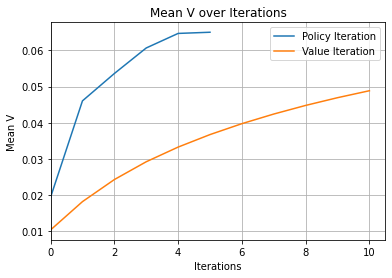

In [219]:
lake_mdp_slippery_s8.compare_plot('Mean V')

In [235]:
lake_mdp_slippery_s8.time_record

{'pi': 0.002128124237060547, 'vi': 0.0006101131439208984}

In [221]:
tmp_df = lake_mdp_slippery_s8.pi_df[lake_mdp_slippery_s8.pi_df['gamma']==lake_mdp_slippery_s8.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp_slippery_s8.vi_df[lake_mdp_slippery_s8.vi_df['gamma']==lake_mdp_slippery_s8.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

# tmp_df = lake_mdp_slippery_s8.q_df[lake_mdp_slippery_s8.q_df['gamma']==lake_mdp_slippery_s8.best_gamma['pi']]
# meanv = tmp_df['Mean V'].max()
# run_time = tmp_df['Time'].max()
# print(meanv)

0.06501543553258703
0.04886257983229166


In [222]:
gamma = lake_mdp_slippery_s8.best_gamma['pi']
num_iters = lake_mdp_slippery_s8.pi_df[lake_mdp_slippery_s8.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp_slippery_s8.best_gamma['vi']
num_iters = lake_mdp_slippery_s8.vi_df[lake_mdp_slippery_s8.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

6
11


In [224]:
np.reshape(lake_mdp_slippery_s8.pi.policy, (8,8))

array([[0, 0, 0, 0, 2, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [3, 3, 3, 2, 2, 2, 2, 1],
       [3, 0, 0, 2, 2, 3, 2, 1],
       [3, 0, 0, 2, 0, 0, 2, 2],
       [0, 0, 1, 2, 1, 1, 0, 2],
       [3, 0, 0, 2, 2, 3, 1, 1],
       [0, 0, 1, 2, 0, 0, 2, 0]])

In [238]:
np.reshape(lake_mdp_slippery_s8.vi.policy, (8,8))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 2, 1, 3],
       [1, 2, 3, 1, 1, 2, 0, 0],
       [3, 3, 0, 0, 0, 2, 0, 1],
       [2, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 2, 2, 2, 1, 0]])

In [236]:
%%time
lake_mdp_non_slippery_s8 = MDP(problem = 'FrozenLake-v1', state_size=8, is_run_q=False, is_slippery=False)

PI completed
VI completed
CPU times: user 71.8 ms, sys: 4.37 ms, total: 76.2 ms
Wall time: 74.7 ms


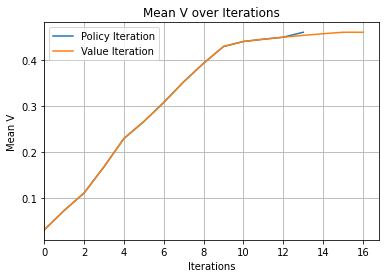

In [226]:
lake_mdp_non_slippery_s8.compare_plot('Mean V')

In [237]:
lake_mdp_non_slippery_s8.time_record

{'pi': 0.003990888595581055, 'vi': 0.0007181167602539062}

In [228]:
tmp_df = lake_mdp_non_slippery_s8.pi_df[lake_mdp_non_slippery_s8.pi_df['gamma']==lake_mdp_non_slippery_s8.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

tmp_df = lake_mdp_non_slippery_s8.vi_df[lake_mdp_non_slippery_s8.vi_df['gamma']==lake_mdp_non_slippery_s8.best_gamma['pi']]
meanv = tmp_df['Mean V'].max()
run_time = tmp_df['Time'].max()
print(meanv)

# tmp_df = lake_mdp_slippery_s8.q_df[lake_mdp_slippery_s8.q_df['gamma']==lake_mdp_slippery_s8.best_gamma['pi']]
# meanv = tmp_df['Mean V'].max()
# run_time = tmp_df['Time'].max()
# print(meanv)

0.4607861757226276
0.4607861757226276


In [229]:
gamma = lake_mdp_non_slippery_s8.best_gamma['pi']
num_iters = lake_mdp_non_slippery_s8.pi_df[lake_mdp_non_slippery_s8.pi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

gamma = lake_mdp_non_slippery_s8.best_gamma['vi']
num_iters = lake_mdp_non_slippery_s8.vi_df[lake_mdp_non_slippery_s8.vi_df['gamma']==gamma]['Iteration'].max()
print(num_iters)

14
17


In [239]:
np.reshape(lake_mdp_non_slippery_s8.pi.policy, (8,8))

array([[1, 1, 2, 2, 1, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 3],
       [1, 1, 0, 0, 2, 2, 1, 0],
       [1, 1, 0, 1, 0, 0, 1, 1],
       [1, 1, 2, 2, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 2, 1, 1],
       [2, 2, 2, 1, 1, 0, 1, 1],
       [0, 3, 0, 2, 2, 2, 2, 0]])

In [242]:
np.sum(np.reshape(lake_mdp_non_slippery_s8.pi.policy, (8,8)))

65

In [243]:
np.sum(np.reshape(lake_mdp_non_slippery_s8.vi.policy, (8,8)))

65

In [ ]:
# https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualising-the-policy